In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [6]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:43773 Dashboard: /proxy/40551/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


In [7]:
session = cc.database.create_session('/g/data/ik11/databases/iaf_jrav140.db')

In [8]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_IAF',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01'})
                        ])

In [5]:
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    dir = exptdict[ekey]['dir']
    cc.database.build_index('/g/data/ik11/outputs/'+dir+'/'+expt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 9926/9926 [43:42<00:00,  3.79it/s]  


Indexing experiment: 01deg_jra55v140_iaf


100%|██████████| 6147/6147 [27:03<00:00,  3.79it/s]


## Just checking the final data for each expt.

In [9]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '1970-01-01'
print(' Setting end_time to',end_time)

01deg_jra55v13_ryf9091 goes from 1900 to 2099
01deg_jra55v140_iaf goes from 1958 to 1966
 Setting end_time to 1970-01-01


## Scalar diagnostics

In [10]:
def plot_timeseries(variable,end_time):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 8.68 s, sys: 979 ms, total: 9.66 s
Wall time: 13 s


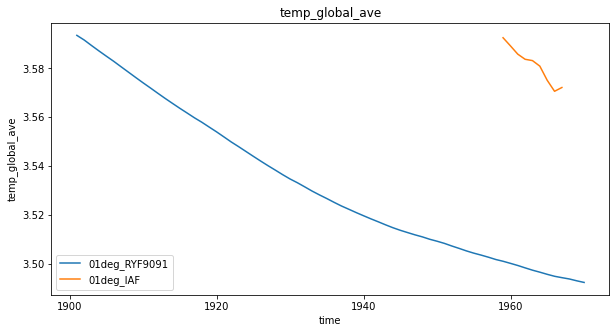

In [11]:
%%time
plot_timeseries('temp_global_ave',end_time)

### Global Average Salinity

CPU times: user 8.69 s, sys: 913 ms, total: 9.6 s
Wall time: 12.8 s


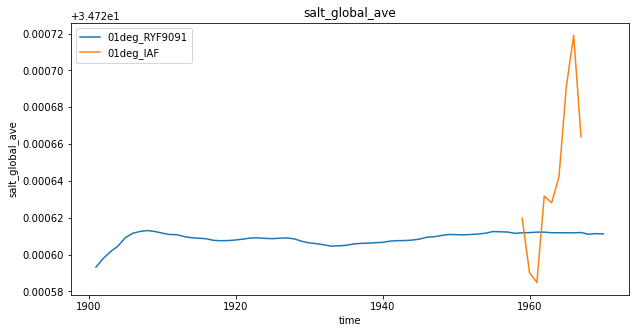

In [12]:
%%time
plot_timeseries('salt_global_ave',end_time)

### Surface Temperature

CPU times: user 9.01 s, sys: 979 ms, total: 9.98 s
Wall time: 13.4 s


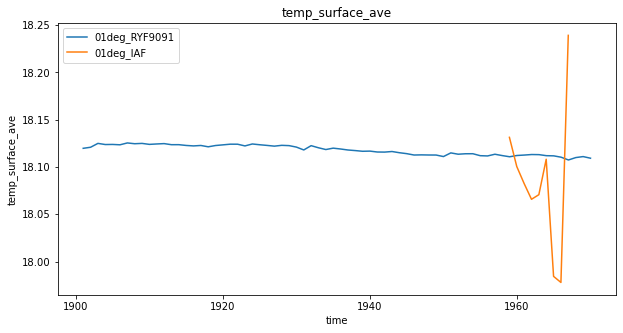

In [13]:
%%time
plot_timeseries('temp_surface_ave',end_time)

### Surface Salinity

CPU times: user 9.12 s, sys: 906 ms, total: 10 s
Wall time: 13.5 s


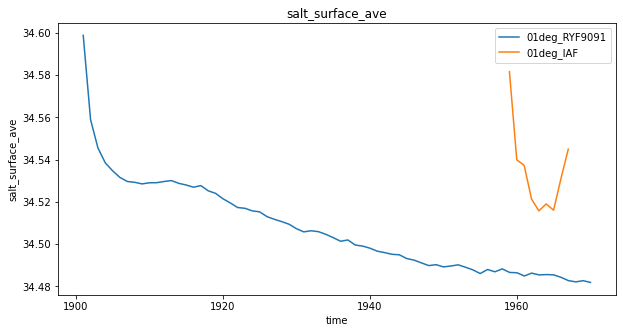

In [14]:
%%time
plot_timeseries('salt_surface_ave',end_time)

### Total Kinetic Energy

CPU times: user 8.94 s, sys: 941 ms, total: 9.88 s
Wall time: 13.1 s


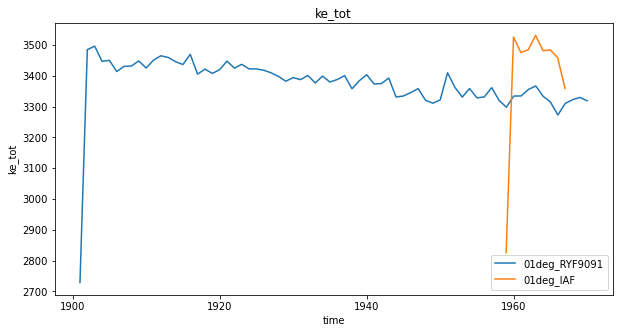

In [15]:
%%time
plot_timeseries('ke_tot',end_time)

## Area-Averaged Tracer Diagnostics

In [30]:
def plot_upper_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 20min 50s, sys: 2min 13s, total: 23min 3s
Wall time: 28min 46s


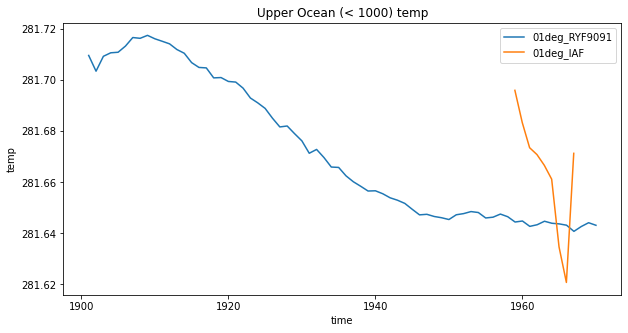

In [31]:
%%time
plot_upper_ocean('temp',end_time)

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 21min 12s, sys: 2min 22s, total: 23min 34s
Wall time: 29min 43s


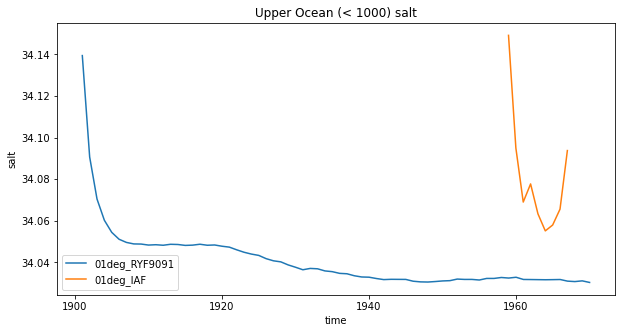

In [32]:
%%time
plot_upper_ocean('salt',end_time)

### Deep Ocean Temperature/Salinity

In [27]:
def plot_lower_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 6min 57s, sys: 41 s, total: 7min 38s
Wall time: 9min 2s


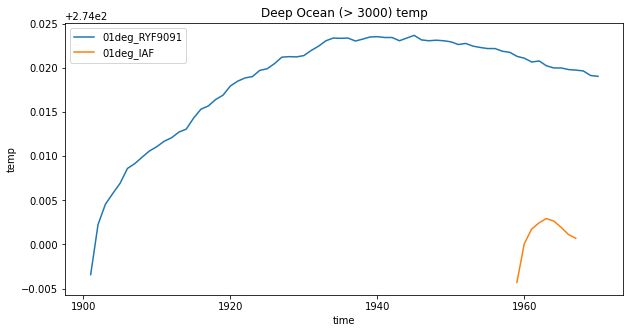

In [28]:
%%time
plot_lower_ocean('temp',end_time)

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 7min 14s, sys: 44.5 s, total: 7min 58s
Wall time: 9min 21s


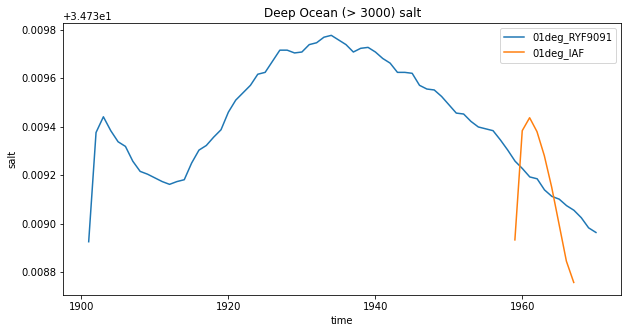

In [29]:
%%time
plot_lower_ocean('salt',end_time)

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 14.3 s, sys: 1.48 s, total: 15.8 s
Wall time: 26.3 s


Text(0.5, 1.0, 'ACC Transport')

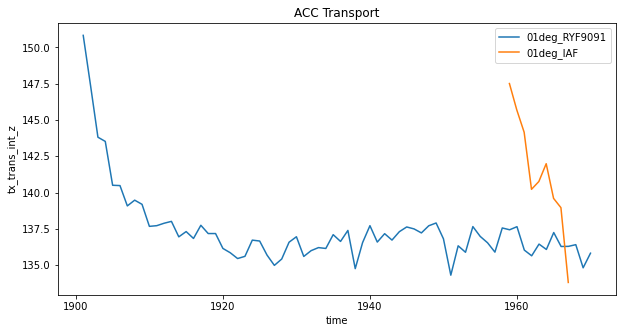

In [16]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

**To Do** - add GM to this.

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 4min 32s, sys: 17.4 s, total: 4min 50s
Wall time: 5min 16s


Text(0.5, 1.0, 'AABW Cell')

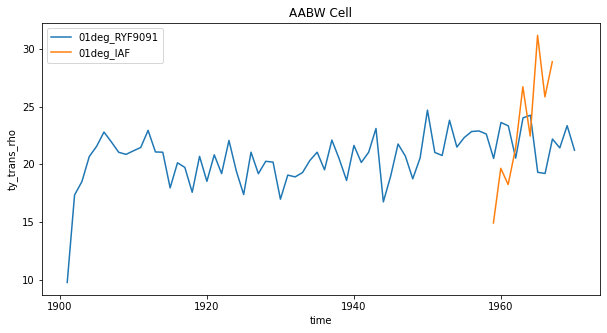

In [17]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 2min 25s, sys: 9.58 s, total: 2min 35s
Wall time: 2min 58s


Text(0.5, 1.0, 'AMOC Cell')

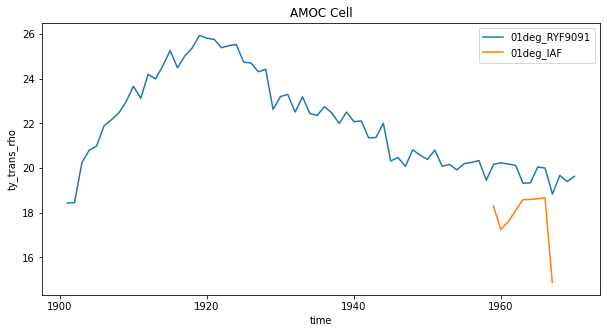

In [22]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [18]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

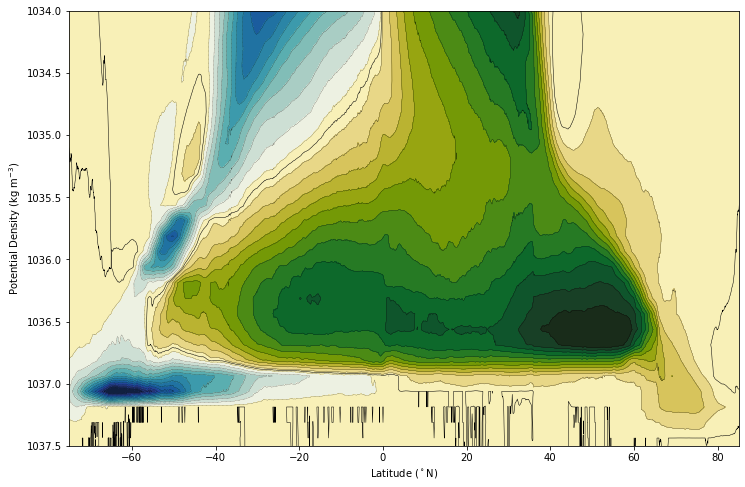

In [23]:
psi = cc.querying.getvar('01deg_jra55v140_iaf','ty_trans_rho',session,end_time='2066-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

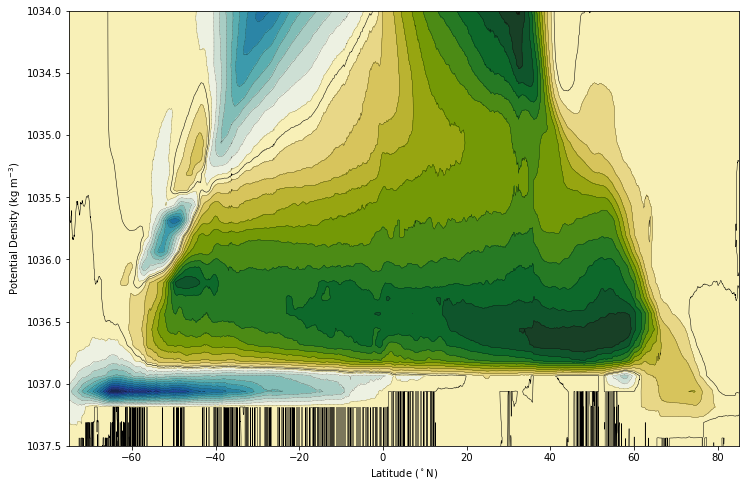

In [20]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2058-01-01', end_time='2066-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 720x648 with 0 Axes>

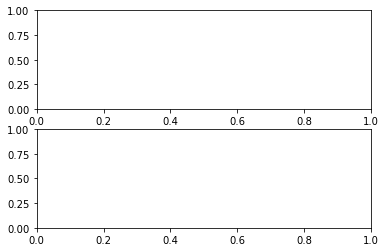

In [21]:
variable='aice_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

In [22]:
variable='aice_m'
expt = exptdict['01deg_RYF9091']['expt']
var = cc.querying.getvar(expt,variable,session,decode_coords=False)

In [23]:
var

,Array,Chunk
Bytes,93.31 GB,2.43 MB
Shape,"(2400, 2700, 3600)","(1, 675, 900)"
Count,79200 Tasks,38400 Chunks
Type,float32,numpy.ndarray


In [24]:
area_t = cc.querying.getvar(expt, 'area_t',session,n=1)

In [25]:
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [ ]:
area = var*area_t
area_zonalsum = area.sum('xt_ocean')
SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
SH_area.plot()